In [39]:
%reset

In [8]:
import os
import json
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import matplotlib
import seaborn as sns

sns.reset_orig()
sns.set()

import random


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

import torch
import torchvision
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
from torch.utils.data import Subset

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [10]:
class TraficDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)

In [80]:
dataset = datasets.ImageFolder(root="data")
trafic_dataset = TraficDataset(dataset, transform=transforms.ToTensor())


def get_train_images(num):
    return torch.stack(
        [trafic_dataset[random.randint(0, 20000)][0] for i in range(10, 10 + num)],
        dim=0,
    )

In [26]:
def get_mean_std(loader):
    num_pixels = 0
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        for i in range(num_channels):
            mean[i] += images[:, i, :, :].mean()
            std[i] += images[:, i, :, :].std()
    mean.div_(len(loader))
    std.div_(len(loader))
    print(mean, std)

    return mean, std


loader = torch.utils.data.DataLoader(
    trafic_dataset, batch_size=32, shuffle=True, num_workers=10, drop_last=True
)
mean, std = get_mean_std(loader)

tensor([0.3187, 0.2930, 0.3015]) tensor([0.2740, 0.2631, 0.2670])


In [27]:
def denormalize(img):
    for channel in range(3):
        img[channel] = (img[channel] * std[channel]) + mean[channel]
    return img

In [28]:
normalize_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
torch.manual_seed(73)
n_train_examples = int(len(dataset) * 0.9)
train_indices, validation_indices = random_split(
    range(len(dataset)), [n_train_examples, len(dataset) - n_train_examples]
)

validation_dataset = TraficDataset(
    Subset(dataset, validation_indices), transform=normalize_transform
)
train_dataset = TraficDataset(
    Subset(dataset, train_indices), transform=normalize_transform
)

validation_loader = DataLoader(
    validation_dataset, batch_size=128, shuffle=False, drop_last=True, num_workers=10
)
train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=10,
)

In [16]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(
            torch.randn([n_imgs, model.latent_dim]).to(device)
        )
    generated_imgs = generated_imgs.cpu()
    generate_images = [denormalize(img) for img in generated_imgs]

    grid = torchvision.utils.make_grid(generated_imgs, nrow=8, normalize=False)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(15, 10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

In [17]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False)
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10, 10))
    else:
        plt.figure(figsize=(15, 10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

# VAE

In [62]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.conv2 = nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=2
        )
        self.conv4 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.conv5 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
        )
        self.fc_1 = nn.Linear(128 * 16 * 16, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.conv2 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=3,
            output_padding=0,
            padding=1,
            stride=1,
        )
        self.conv3 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=32,
            kernel_size=3,
            output_padding=0,
            padding=1,
            stride=1,
        )
        self.conv4 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=16,
            kernel_size=5,
            output_padding=1,
            padding=2,
            stride=2,
        )
        self.conv5 = nn.ConvTranspose2d(
            in_channels=16,
            out_channels=3,
            kernel_size=3,
            output_padding=0,
            padding=1,
            stride=1,
        )
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, 128 * 16 * 16)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.fc_1(x))
        h = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 128, 16, 16])
        x_hat = F.leaky_relu(self.conv2(x_hat))
        x_hat = F.leaky_relu(self.conv3(x_hat))
        x_hat = F.leaky_relu(self.conv4(x_hat))
        x_hat = F.leaky_relu(self.conv5(x_hat))
        return x_hat

In [63]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(
            input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim
        )
        self.decoder = Decoder(
            latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim
        )

    def reparameterization(self, mean, var):
        # Change to proper sampling
        z = torch.randn_like(mean) * var + mean
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(
            mean, torch.exp(0.5 * log_var)
        )  # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [64]:
vae = VAE(latent_dim=128, hidden_dim=1028, x_dim=3072).to(device)
vae

VAE(
  (encoder): Encoder(
    (conv2): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc_1): Linear(in_features=32768, out_features=1028, bias=True)
    (fc_2): Linear(in_features=1028, out_features=1028, bias=True)
    (fc_mean): Linear(in_features=1028, out_features=128, bias=True)
    (fc_var): Linear(in_features=1028, out_features=128, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (conv5): ConvTranspo

In [30]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [65]:
optimizer = optim.Adam(vae.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [72]:
num_epochs = 100
for n in range(num_epochs):
    vae.train()
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    L1_list = []
    #     if n % 10 == 0:
    vae.eval()
    for x, _ in iter(validation_loader):
        x = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out - x)).item())
    print(
        f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, Validation L1 = {np.mean(L1_list)}"
    )
    scheduler.step()

Epoch 0 loss 67833.41463275548, Validation L1 = 0.21729715317487716
Epoch 1 loss 67828.05217837592, Validation L1 = 0.2171445737282435
Epoch 2 loss 67753.60526916059, Validation L1 = 0.21740008741617203
Epoch 3 loss 67649.24860287408, Validation L1 = 0.2171507293979327
Epoch 4 loss 67630.20805770985, Validation L1 = 0.21712399820486705
Epoch 5 loss 67506.69562614051, Validation L1 = 0.21695701380570728
Epoch 6 loss 67445.29008895985, Validation L1 = 0.21687838286161423
Epoch 7 loss 67379.64889370438, Validation L1 = 0.21665402501821518
Epoch 8 loss 67360.65485287408, Validation L1 = 0.21680463552474977
Epoch 9 loss 67275.69819229015, Validation L1 = 0.216695374250412
Epoch 10 loss 67191.0569685219, Validation L1 = 0.2165251652399699
Epoch 11 loss 67156.39458827555, Validation L1 = 0.2166470726331075
Epoch 12 loss 67091.23845232664, Validation L1 = 0.21656881421804428
Epoch 13 loss 67029.38027486314, Validation L1 = 0.21655532568693162
Epoch 14 loss 66949.54881386862, Validation L1 = 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


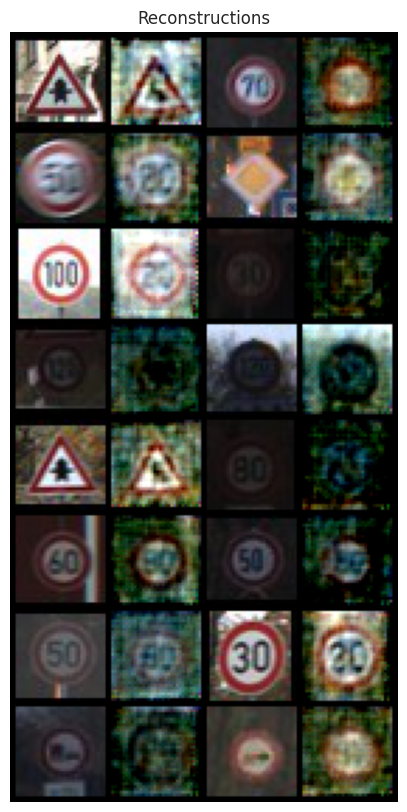

In [73]:
input_imgs = get_train_images(16)
vae.eval()
visualize_reconstructions(vae, input_imgs, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


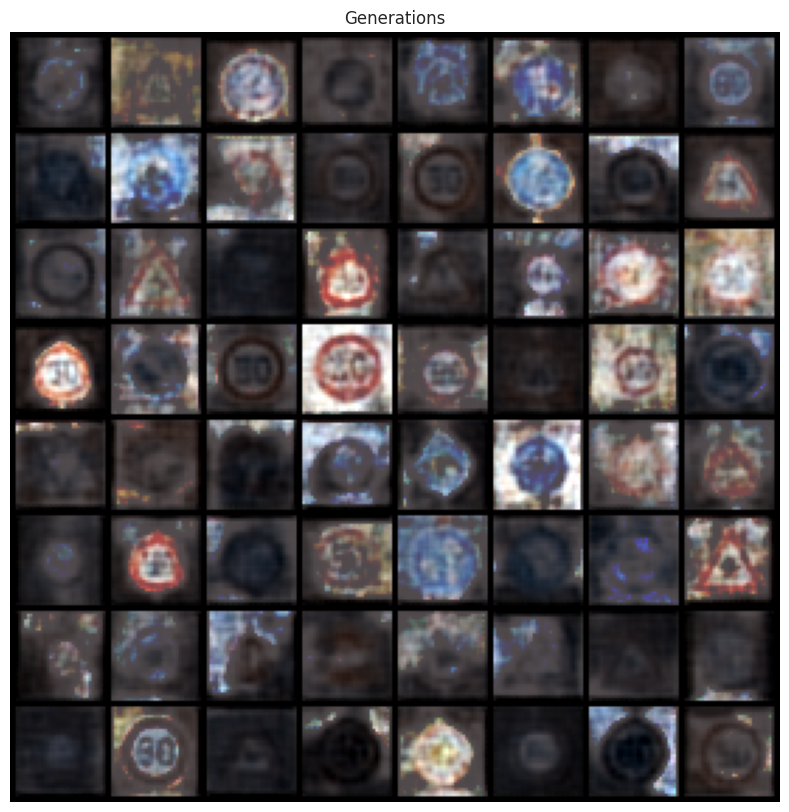

In [74]:
vae.eval()
generate_images(vae, 64, device)

In [78]:
torch.save(vae, "even_better_945.model")

# GAN

# GLOW

# VAEGAN

https://github.com/lucabergamini/VAEGAN-PYTORCH

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.conv2 = nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=0
        )
        self.conv3 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2
        )
        self.conv4 = nn.Conv2d(
            in_channels=32, out_channels=128, kernel_size=3, stride=2, padding=1
        )
        self.fc_1 = nn.Linear(128 * 8 * 8, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)  # encoder produces mean and log of variance
        #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(Decoder, self).__init__()

        self.conv2 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=32,
            kernel_size=3,
            output_padding=1,
            padding=1,
            stride=2,
        )
        self.conv3 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=16,
            kernel_size=5,
            output_padding=0,
            padding=2,
            stride=1,
        )
        self.conv4 = nn.ConvTranspose2d(
            in_channels=16,
            out_channels=3,
            kernel_size=3,
            output_padding=1,
            padding=1,
            stride=2,
        )
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, 128 * 8 * 8)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.fc_1(x))
        h = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 128, 8, 8])
        x_hat = F.leaky_relu(self.conv2(x_hat))
        x_hat = F.leaky_relu(self.conv3(x_hat))
        x_hat = F.leaky_relu(self.conv4(x_hat))
        return x_hat


class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [ ]:
class VaeGan(nn.Module):
    def __init__(self):
        self.encoder = Encoder(hidden_dim=1024, latent_dim=256)
        self.decoder = Decoder(hidden_dim=1024, latent_dim=256)
        self.discriminator = Discriminator()

# Plot Laten

In [32]:
import umap.umap_ as umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

/home/mikic202/miniconda3/envs/pt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
def plot_latent(train_embedded, train_img_embeds, n_data=5000):
    data = pd.DataFrame(train_embedded[:n_data])
    data["label"] = train_img_embeds[2][:n_data].cpu().numpy()
    examples = []
    examples_locations = []
    for i in np.random.randint(0, n_data, 40):
        examples.append(train_img_embeds[0][i].squeeze(0).cpu().numpy())
        examples_locations.append(data.iloc[i])
    fig, ax = plt.subplots(figsize=(12, 10))
    # ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
    sns.scatterplot(
        x=0,
        y=1,
        hue="label",
        palette=sns.color_palette("hls", 10),
        data=data,
        legend="full",
        alpha=0.1,
    )
    for location, example in zip(examples_locations, examples):
        x, y = location[0], location[1]
        label = int(location["label"])
        ab = AnnotationBbox(
            OffsetImage(example, cmap=plt.cm.gray_r, zoom=1),
            (x, y),
            frameon=True,
            bboxprops=dict(
                facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"
            ),
        )
        ax.add_artist(ab)
    plt.show()

In [34]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in data_loader:
        with torch.no_grad():
            mean, var_log = model.encoder(imgs.to(device))
        img_list.append(imgs)
        embed_list.append(mean)
        labels.append(label)
    return (
        torch.cat(img_list, dim=0),
        torch.cat(embed_list, dim=0),
        torch.cat(labels, dim=0),
    )

/tmp/ipykernel_12133/3405868225.py:11: UserWarning: 
The palette list has fewer values (10) than needed (43) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


TypeError: Invalid shape (3, 32, 32) for image data

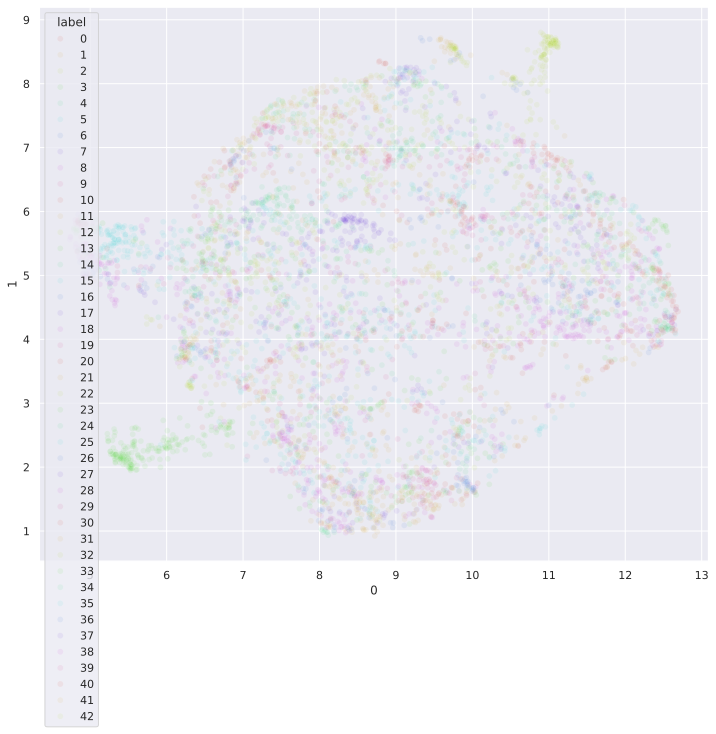

In [35]:
umap_object = umap.UMAP(metric="cosine", n_neighbors=100)
train_img_embeds = embed_imgs(vae, train_loader)
# test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = umap_object.fit_transform(train_img_embeds[1][:5000].cpu())
plot_latent(train_embedded, train_img_embeds)

# Evaluator

In [44]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert (
        mu1.shape == mu2.shape
    ), "Training and test mean vectors have different lengths"
    assert (
        sigma1.shape == sigma2.shape
    ), "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = (
            "fid calculation produces singular product; "
            "adding %s to diagonal of cov estimates"
        ) % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

In [37]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out = nn.Linear(50, 43)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x

    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x


evaluator = Evaluator(32 * 32 * 3, 256).to(device)

In [38]:
# Optimizers
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.98)

# loss
criterion = nn.CrossEntropyLoss()

In [39]:
num_epochs = 15
for epoch in range(num_epochs):
    for data, targets in iter(train_loader):
        data, targets = data.to(device), targets.to(device)

        results = evaluator(data)
        loss = criterion(results, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [40]:
correct = 0
guesses = 0

evaluator.eval()
with torch.no_grad():
    for data, targets in iter(validation_loader):
        # Sends data and targets to device
        data = data.to(device)
        targets = targets.to(device)

        # Acquires the network's best guesses at each class
        results = evaluator(data)
        best_guesses = torch.argmax(results, 1)

        # Updates number of correct and total guesses
        correct += torch.eq(targets, best_guesses).sum().item()
        guesses += len(targets)

print("Correctly guessed ", correct / guesses * 100, "% of the dataset")

Correctly guessed  91.45833333333333 % of the dataset


In [75]:
latent_dim = 128

with torch.no_grad():
    fixed_noise = torch.randn(1000, latent_dim, device=device)
    generations_vae = vae.decoder(fixed_noise)
    generations_vae = denormalize(generations_vae)
    print(generations_vae.shape)

torch.Size([1000, 3, 32, 32])


In [76]:
orig_data = [x[0] for x in list(validation_dataset)[:1000]]
orig_data = torch.tensor(np.array(orig_data))
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()

In [77]:
calculate_frechet_distance(dist_orig_data.numpy(), dist_vae.numpy())

945.4607078841136